### This is Email Bot for Company which will send and read Emails for the Company by fetching the data from the database

In [1]:
from langchain.agents import create_agent

c:\Users\ASUS\AppData\Local\Programs\Python\Python314\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1
c:\Users\ASUS\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_groq import ChatGroq
from langchain.tools import tool


In [3]:
import requests
import os

In [12]:
from langchain.agents.middleware import SummarizationMiddleware,HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from dotenv import load_dotenv
from langchain.messages import HumanMessage,SystemMessage

In [5]:
load_dotenv()

True

In [6]:
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0.1,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    # other params...
)

In [56]:
from langchain.tools import tool

@tool
def get_users(name:str,role:str) -> str:
    """
    Get user data using name and role

    Args:
        name (str): The name of the user in database
        role (str): The role of the user in database
    
    Returns:
        str: A list of users or one user only

    """
    
    try:
        response = requests.get(
            'http://localhost:3000/users?role=Manager&name=HariBhandari'
        )
        response.raise_for_status()
        return response.json()
    except requests.exceptions.HTTPError as err:
        return f"Error: {err}"
    

@tool
def send_email(to: str, subject: str, body: str) -> str:
    """Send an email to the specified recipient with the specified subject and body."""
    try:
        response = requests.post('http://localhost:3000/users/send-email',
            json={
                "to": to,
                "subject": subject,
                "body": body,
                "from":"n31mahesh@gmail.com",
                "pass":'app password'
            }
        )
        response.raise_for_status()
        return f"Email sent to {to} with resonse: {response.json()}"
    except requests.exceptions.HTTPError as err:
        return f"Error: {err}"
    except Exception as e:
        return (
            f"An error occurred while sending the email to {to}: {e}"
        )

@tool
def read_email(to: str) -> str:
    """Read an email from the specified recipient."""
    return f"Email read from {to}"

In [57]:
# res = send_email("n31mahesh@gmail.com","hello my friend","hello my friend")
# print(res)

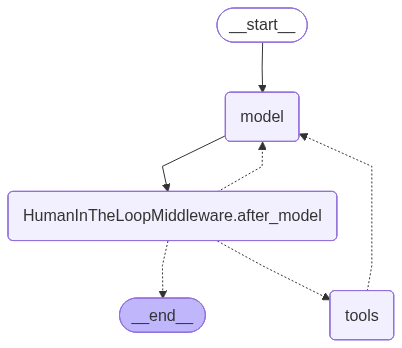

In [43]:
tools = [get_users,send_email,read_email]
agent_email = create_agent(
    model = llm,
    tools = tools,
    checkpointer = InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email": False,
            }
        )
    ]
)

agent_email

In [44]:
config = {'configurable':{'thread_id':'test4'}}

In [45]:
result = agent_email.invoke({'messages':[HumanMessage(content="send email with hello my friend with subject hello my friend to Hari Bhandari whose role in company is Manager"),SystemMessage(content="You are an email bot which first fetch user data then send email if requested role or name is in database returned from get_users tool then send email to the person.")]},config=config)
print(result)

{'messages': [HumanMessage(content='send email with hello my friend with subject hello my friend to Hari Bhandari whose role in company is Manager', additional_kwargs={}, response_metadata={}, id='9c3cb4d4-684a-4575-befb-ed00250bdfb6'), SystemMessage(content='You are an email bot which first fetch user data then send email if requested role or name is in database returned from get_users tool then send email to the person.', additional_kwargs={}, response_metadata={}, id='52ff962b-10aa-41cf-a3bd-2c3938d6609b'), AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user wants to send an email to Hari Bhandari, who is a Manager. The subject and body are both "hello my friend". \n\nFirst, I need to check if Hari Bhandari exists in the database. The get_users function requires both name and role. So I should call get_users with name "Hari Bhandari" and role "Manager". \n\nOnce I get the user data, if it exists, then I can proceed to send the email using send_e

In [46]:
print(result['messages'])

[HumanMessage(content='send email with hello my friend with subject hello my friend to Hari Bhandari whose role in company is Manager', additional_kwargs={}, response_metadata={}, id='9c3cb4d4-684a-4575-befb-ed00250bdfb6'), SystemMessage(content='You are an email bot which first fetch user data then send email if requested role or name is in database returned from get_users tool then send email to the person.', additional_kwargs={}, response_metadata={}, id='52ff962b-10aa-41cf-a3bd-2c3938d6609b'), AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user wants to send an email to Hari Bhandari, who is a Manager. The subject and body are both "hello my friend". \n\nFirst, I need to check if Hari Bhandari exists in the database. The get_users function requires both name and role. So I should call get_users with name "Hari Bhandari" and role "Manager". \n\nOnce I get the user data, if it exists, then I can proceed to send the email using send_email function

In [47]:
from langgraph.types import Command

response = agent_email.invoke(
    Command( 
        resume={"decisions": [{"type": "approve"}]}  # or "reject"
    ), 
    config=config # Same thread ID to resume the paused conversation
)
print(response['messages'][-1])

content='The email with the subject "hello my friend" has been successfully sent to Hari Bhandari\'s email address (maheshbhandari2061@gmail.com). Let me know if you need anything else!' additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user wanted to send an email to Hari Bhandari, who is a Manager. First, I used the get_users function to find Hari\'s email address. The response from get_users gave me the email "maheshbhandari2061@gmail.com". Then, I called the send_email function with the provided body and subject, addressing the email to that email address. The send_email response said the email was sent successfully. Now, I need to inform the user that the email was sent. I should mention that it was sent to Hari Bhandari\'s email address as per the database. Let me check if there\'s any more steps needed. No, I think that\'s all. Just confirm the successful sending and maybe offer further help.\n'} response_metadata={'token_usage': {'completion_tokens': 208, 'prompt_t